<img src="slides/6.png">

## ローンデータセット

ローンのデータセットを決定木により分析。

In [1]:
import pandas as pd
import numpy as np
loan = pd.read_csv('data/loan_data.csv')

# 使用しない列を削除
df = loan.drop(['Unnamed: 0', 'status', 'loan_amnt', 'term', 'annual_inc', 'dti',
                  'revol_bal', 'revol_util', 'purpose', 'home_ownership',
                  'delinq_2yrs_zero', 'pub_rec_zero', 'open_acc', 'grade'], axis=1)
# 確認
df

,payment_inc_ratio,outcome,emp_length,purpose_,home_,emp_len_,borrower_score
0,2.39320,default,1,major_purchase,RENT,> 1 Year,0.65
1,4.57170,default,5,small_business,OWN,> 1 Year,0.80
2,9.71600,default,1,other,RENT,> 1 Year,0.60
3,12.21520,default,1,debt_consolidation,RENT,> 1 Year,0.50
4,3.90888,default,4,other,RENT,> 1 Year,0.55
...,...,...,...,...,...,...,...
45337,4.57850,paid off,8,credit_card,RENT,> 1 Year,0.35
45338,3.20333,paid off,3,other,MORTGAGE,> 1 Year,0.50
45339,9.98460,paid off,1,debt_consolidation,MORTGAGE,> 1 Year,0.55
45340,6.45250,paid off,1,debt_consolidation,MORTGAGE,> 1 Year,0.65


### ダミー変数化

カテゴリカル変数について pos_label で正例ラベルを指定せずに、正確度、適合度、再現率を計算できるようにするため、目的変数もダミー変数化

- ダミー変数化すると、決定木の描画時に文字列のクラスラベルを指定する必要が出てくる

In [2]:
# ダミー変数化
df['outcome'] = df['outcome'].map(lambda x: 1 if x == 'default' else 0)
df = pd.get_dummies(data=df)
# 確認
# - 0行: default -> 1
# - 45341行: paid off -> 0
df.iloc[[0, 45341]]

,payment_inc_ratio,outcome,emp_length,borrower_score,purpose__credit_card,purpose__debt_consolidation,purpose__home_improvement,purpose__major_purchase,purpose__medical,purpose__other,purpose__small_business,home__MORTGAGE,home__OWN,home__RENT,emp_len__ < 1 Year,emp_len__ > 1 Year
0,2.3932,1,1,0.65,0,0,0,1,0,0,0,0,0,1,0,1
45341,11.8715,0,9,0.50,0,1,0,0,0,0,0,1,0,0,0,1


### 決定木の作成

決定木の深さは max_depth=2

In [3]:
# 説明変数、目的変数を作成
Y_label = 'outcome'
X = df.drop([Y_label], axis=1)
Y = df[Y_label]

# 決定木を作成
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(criterion='entropy', max_depth=2)
model.fit(X, Y)

DecisionTreeClassifier(criterion='entropy', max_depth=2)

### 精度の計算・表示

max_depth=2 のため、精度は高くない

- ダミー変数化したため pos_label で正例ラベルの指定が不要

In [4]:
# 正確度、適合度、再現率（感度）、AUCの算出
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
Y_predict = model.predict(X)
Y_proba = model.predict_proba(X)
fpr, tpr, thresholds = roc_curve(Y, Y_proba[:, 1])
print('正確度={:.3f}, 適合度={:.3f}, 再現率={:.3f}, AUC={:.3f}'.format(
    accuracy_score(Y, Y_predict), precision_score(Y, Y_predict),
    recall_score(Y, Y_predict), auc(fpr, tpr)))

正確度=0.613, 適合度=0.632, 再現率=0.542, AUC=0.650


### 決定木の描画

In [5]:
model.classes_

array([0, 1])

ダミー変数化により model.classes_ が文字列ではなくなり、数値となったため```class_names=model.classes_```での分類クラス名の設定がエラーになるため、分類クラス名の文字列を指定する必要

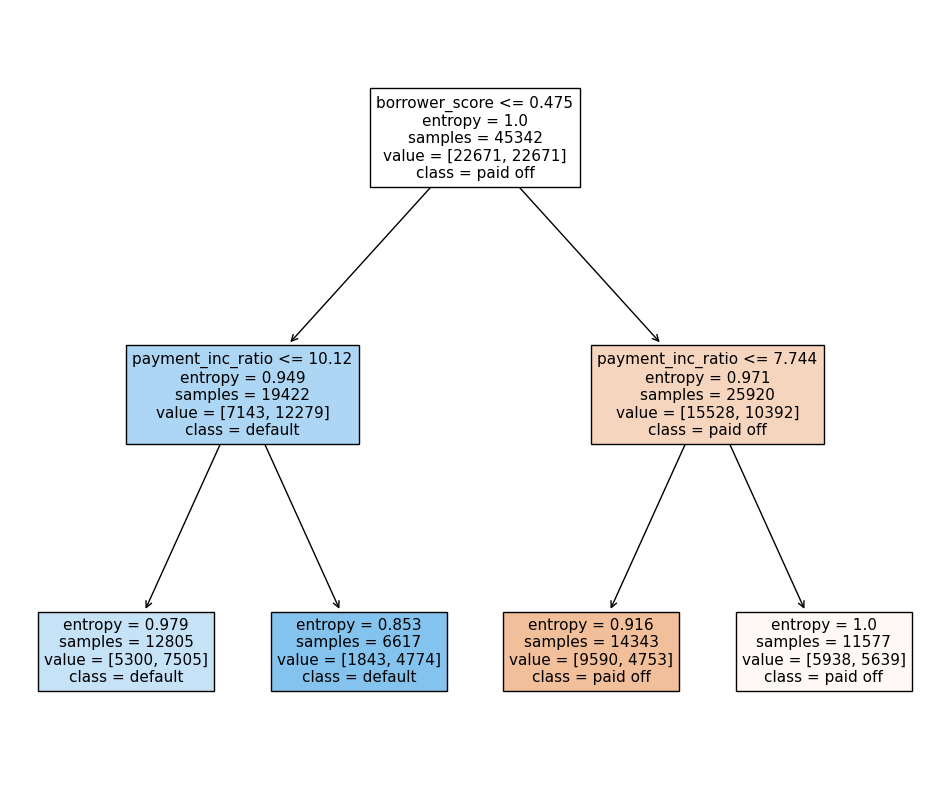

In [6]:
# 作成した決定木の描画
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plt.figure(figsize=(12, 10))
# plot_tree(model, feature_names=X.columns, class_names=model.classes_, filled=True)
# - class_names=model.classes_ のままだとエラーになるため、文字列を指定
plot_tree(model, feature_names=X.columns, class_names=['paid off', 'default'], filled=True)
plt.show()

### 情報利得の総和

説明変数の重要度

In [7]:
# 情報利得の総和
pd.DataFrame(model.feature_importances_, index=X.columns, columns=['gain']).\
    sort_values('gain', ascending=False)

,gain
borrower_score,0.706099
payment_inc_ratio,0.293901
emp_length,0.000000
purpose__credit_card,0.000000
purpose__debt_consolidation,0.000000
purpose__home_improvement,0.000000
purpose__major_purchase,0.000000
purpose__medical,0.000000
purpose__other,0.000000
purpose__small_business,0.000000


<img src='slides/8_25.png'>

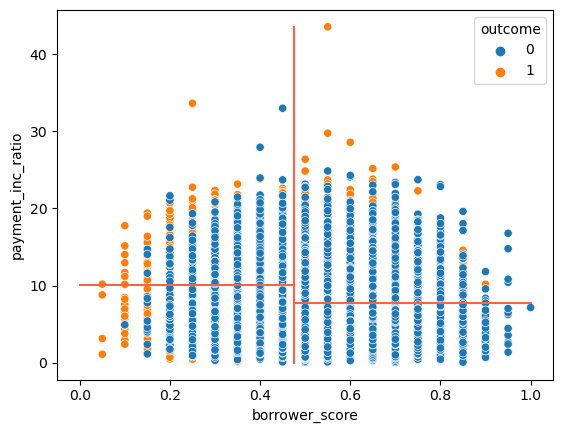

In [8]:
# borrower_score, payment_inc_ratio の散布図
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x=df.borrower_score, y=df.payment_inc_ratio, hue=df.outcome)
plt.plot([0.475, 0.475], [0, df.payment_inc_ratio.max()], color='tomato')
plt.plot([0, 0.475], [10.12, 10.12], color='tomato')
plt.plot([0.475, 1.0], [7.744, 7.744], color='tomato')

全般的に outcome=0 (paid off) の青のプロットが目立つ、右下には outcome=1 (default) が無い（paid off の半分くらいは default がある）、など、決定木の結果 (value) とは違う見え方になっている。データ数が多すぎて、重なり多すぎる可能性がある

データをランダムに間引き、データ数を減らした散布図を描画

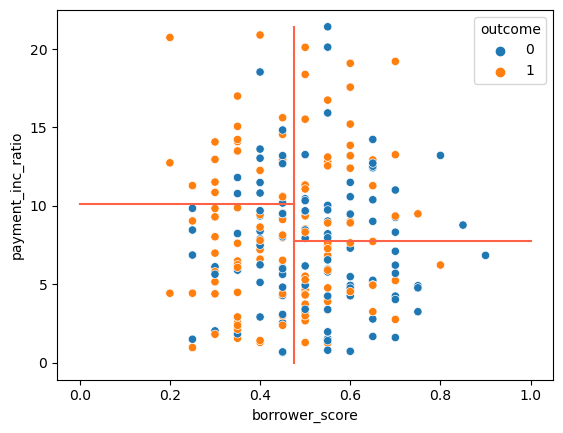

In [9]:
# borrower_score, payment_inc_ratio の散布図
import seaborn as sns
import matplotlib.pyplot as plt

# 0.5% をランダム抽出
df_s = df.sample(frac=0.005)

sns.scatterplot(x=df_s.borrower_score, y=df_s.payment_inc_ratio, hue=df_s.outcome)
plt.plot([0.475, 0.475], [0, df_s.payment_inc_ratio.max()], color='tomato')
plt.plot([0, 0.475], [10.12, 10.12], color='tomato')
plt.plot([0.475, 1.0], [7.744, 7.744], color='tomato')

<img src="slides/7.png">

### 決定木の深さの変更

決定木の深さを max_depth=6 として決定木を作成してみる。

正確度=0.634, 適合度=0.633, 再現率=0.640, AUC=0.688


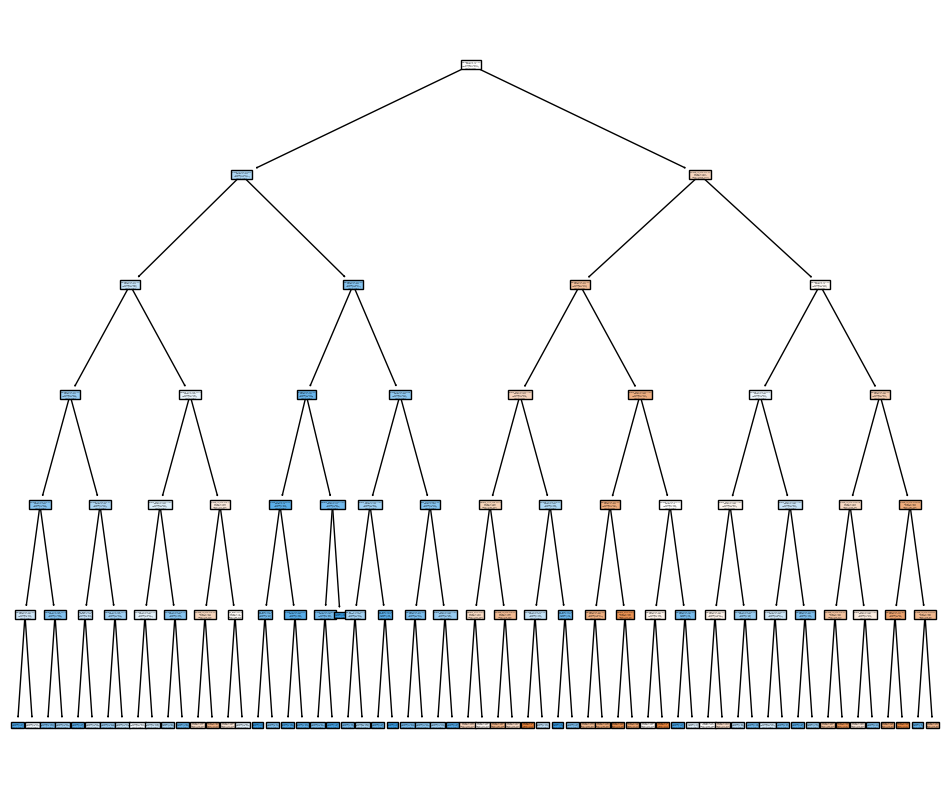

In [10]:
# 決定木を作成
model = DecisionTreeClassifier(criterion='entropy', max_depth=6)
model.fit(X, Y)

# 正確度、適合度、再現率（感度）、AUCの算出
Y_predict = model.predict(X)
Y_proba = model.predict_proba(X)
fpr, tpr, thresholds = roc_curve(Y, Y_proba[:, 1])
print('正確度={:.3f}, 適合度={:.3f}, 再現率={:.3f}, AUC={:.3f}'.format(
    accuracy_score(Y, Y_predict), precision_score(Y, Y_predict),
    recall_score(Y, Y_predict), auc(fpr, tpr)))

# 決定木の描画
plt.figure(figsize=(12, 10))
plot_tree(model, feature_names=X.columns, class_names=['paid off', 'default'], filled=True)
plt.show()

max_depth=6 の決定木は複雑だが、精度はあまり上がらない。